In [3]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import GridSearchCV
# Figures inline and set visualization style
%matplotlib inline
sns.set()

# Import data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Store target variable of training data in a safe place
survived_train = df_train.Survived

# Concatenate training and test sets
data = pd.concat([df_train.drop(['Survived'], axis=1), df_test])

# View head
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [4]:
# View head of 'Name' column
data.Name.tail()

413              Spector, Mr. Woolf
414    Oliva y Ocana, Dona. Fermina
415    Saether, Mr. Simon Sivertsen
416             Ware, Mr. Frederick
417        Peter, Master. Michael J
Name: Name, dtype: object

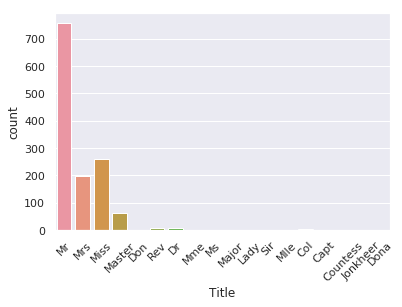

In [5]:
# Extract Title from Name, store in column and plot barplot
data['Title'] = data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

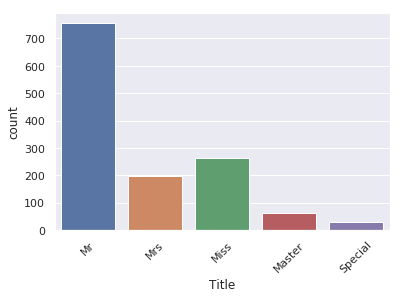

In [6]:
data['Title'] = data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
data['Title'] = data['Title'].replace(['Don', 'Dona', 'Rev', 'Dr',
                                            'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

In [7]:
# View head of data
data.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Special
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Mr
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,Master


In [8]:
# Did they have a Cabin?
data['Has_Cabin'] = ~data.Cabin.isnull()

# View head of data
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Has_Cabin
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False


In [9]:
# Drop columns that are not useful and view head
data.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Has_Cabin
0,3,male,22.0,1,0,7.2500,S,Mr,False
1,1,female,38.0,1,0,71.2833,C,Mrs,True
2,3,female,26.0,0,0,7.9250,S,Miss,False
3,1,female,35.0,1,0,53.1000,S,Mrs,True
4,3,male,35.0,0,0,8.0500,S,Mr,False


In [10]:
# let us check missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Pclass       1309 non-null int64
Sex          1309 non-null object
Age          1046 non-null float64
SibSp        1309 non-null int64
Parch        1309 non-null int64
Fare         1308 non-null float64
Embarked     1307 non-null object
Title        1309 non-null object
Has_Cabin    1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 133.3+ KB


In [11]:
# Impute missing values for Age, Fare, Embarked
data['Age'] = data.Age.fillna(data.Age.median())
data['Fare'] = data.Fare.fillna(data.Fare.median())
data['Embarked'] = data['Embarked'].fillna('S')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Pclass       1309 non-null int64
Sex          1309 non-null object
Age          1309 non-null float64
SibSp        1309 non-null int64
Parch        1309 non-null int64
Fare         1309 non-null float64
Embarked     1309 non-null object
Title        1309 non-null object
Has_Cabin    1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 133.3+ KB


In [12]:
# Binning numerical columns
data['CatAge'] = pd.qcut(data.Age, q=4, labels=False )
data['CatFare']= pd.qcut(data.Fare, q=4, labels=False)
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Has_Cabin,CatAge,CatFare
0,3,male,22.0,1,0,7.2500,S,Mr,False,0,0
1,1,female,38.0,1,0,71.2833,C,Mrs,True,3,3
2,3,female,26.0,0,0,7.9250,S,Miss,False,1,1
3,1,female,35.0,1,0,53.1000,S,Mrs,True,2,3
4,3,male,35.0,0,0,8.0500,S,Mr,False,2,1


In [13]:
data = data.drop(['Age', 'Fare'], axis=1)
data.head()

,Pclass,Sex,SibSp,Parch,Embarked,Title,Has_Cabin,CatAge,CatFare
0,3,male,1,0,S,Mr,False,0,0
1,1,female,1,0,C,Mrs,True,3,3
2,3,female,0,0,S,Miss,False,1,1
3,1,female,1,0,S,Mrs,True,2,3
4,3,male,0,0,S,Mr,False,2,1


In [14]:
# Create column of number of Family members onboard
data['Fam_Size'] = data.Parch + data.SibSp

In [15]:
# Drop columns
data = data.drop(['SibSp','Parch'], axis=1)
data.head()

,Pclass,Sex,Embarked,Title,Has_Cabin,CatAge,CatFare,Fam_Size
0,3,male,S,Mr,False,0,0,1
1,1,female,C,Mrs,True,3,3,1
2,3,female,S,Miss,False,1,1,0
3,1,female,S,Mrs,True,2,3,1
4,3,male,S,Mr,False,2,1,0


In [16]:
# Transform into binary variables
data_dum = pd.get_dummies(data, drop_first=True)
data_dum.head()

,Pclass,Has_Cabin,CatAge,CatFare,Fam_Size,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,3,False,0,0,1,1,0,1,0,1,0,0
1,1,True,3,3,1,0,0,0,0,0,1,0
2,3,False,1,1,0,0,0,1,1,0,0,0
3,1,True,2,3,1,0,0,1,0,0,1,0
4,3,False,2,1,0,1,0,1,0,1,0,0


In [17]:
# Split into test.train
data_train = data_dum.iloc[:891]
data_test = data_dum.iloc[891:]

# Transform into arrays for scikit-learn
X = data_train.values
test = data_test.values
y = survived_train.values

In [18]:
# Setup the hyperparameter grid
dep = np.arange(1,9)
param_grid = {'max_depth' : dep}

# Instantiate a decision tree classifier: clf
clf = tree.DecisionTreeClassifier()

# Instantiate the GridSearchCV object: clf_cv
clf_cv = GridSearchCV(clf, param_grid=param_grid, cv=5)

# Fit it to the data
clf_cv.fit(X, y)

# Print the tuned parameter and score
print("Tuned Decision Tree Parameters: {}".format(clf_cv.best_params_))
print("Best score is {}".format(clf_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 3}
Best score is 0.8294051627384961


In [19]:
Y_pred = clf_cv.predict(test)
df_test['Survived'] = Y_pred
df_test[['PassengerId', 'Survived']].to_csv('dec_tree_feat_eng.csv', index=False)

In [20]:
df_test['Survived']

0      0
1      1
2      0
3      0
4      1
5      0
6      1
7      0
8      1
9      0
10     0
11     0
12     1
13     0
14     1
15     1
16     0
17     0
18     1
19     1
20     0
21     1
22     1
23     0
24     1
25     0
26     1
27     0
28     0
29     0
      ..
388    0
389    0
390    0
391    1
392    1
393    0
394    0
395    1
396    0
397    1
398    0
399    0
400    1
401    0
402    1
403    0
404    0
405    0
406    0
407    0
408    1
409    1
410    1
411    1
412    1
413    0
414    1
415    0
416    0
417    1
Name: Survived, Length: 418, dtype: int64